In [4]:
"""
I start the problem by getting all of the slide images from my folders and saving them to arrays depending on
whether or not the parasite is present in the cell
"""

import os

def load_file_locations(folder):
    locs = []
    for filename in os.listdir(folder):
        locs.append(filename)
    return locs

infected_folder = os.getcwd() + "/MalariaSlides/Infected"
uninfected_folder = os.getcwd() + "/MalariaSlides/Uninfected"

infected_slides = load_file_locations(infected_folder)
uninfected_slides = load_file_locations(uninfected_folder)

In [126]:
"""
From here I am rescaling the images and saving the intensity of the blue color in each of the pixels as my X values
and marking the presence of the parasite with a 1 in the y array
"""

from PIL import Image
import numpy as np

X = []
y = []

for loc in infected_slides:
    image = Image.open(infected_folder + "/" + loc).convert('LA').resize((64,64), Image.ANTIALIAS)
    X.append(np.asarray(image)[:,:,1].flatten())
    y.append(1)
for loc in uninfected_slides:
    image = Image.open(uninfected_folder + "/" + loc).resize((64,64), Image.ANTIALIAS)
    X.append(np.asarray(image)[:,:,1].flatten())
    y.append(0)

In [127]:
"""
Now I standardize the scaling of the features, so each value will indicate how the intensity of the color
compares to corresponding pixels in other slides. Then I split the data into training and testing sets.
"""

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([("std_scaler", StandardScaler())])
X = pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 12)

In [151]:
"""
In order to have some kind of visualization for the classifiers that I'll be testing, I need to do some dimensionality
reduction on the X components, so I'm using a PCA to accomplish that and then generating a scatter plot and using the
difference between the actual and predicted value (1, -1, or 0) to see what kinds of error we're getting and if it
follows any patterns
"""


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

def display_visual(classifier):
    color_marker = y - clf.predict(X)
    X_dim = [[],[],[]]
    Y_dim = [[],[],[]]
    for i in range(len(color_marker)):
        if(color_marker[i] == 1):
            X_dim[0].append(X_pca[i][0])
            Y_dim[0].append(X_pca[i][1])
        elif(color_marker[i] == 0):
            X_dim[1].append(X_pca[i][0])
            Y_dim[1].append(X_pca[i][1])
        else:
            X_dim[2].append(X_pca[i][0])
            Y_dim[2].append(X_pca[i][1])
    plt.scatter(X_dim[0], Y_dim[0], label="False Negative", alpha = .2)
    plt.scatter(X_dim[1], Y_dim[1], label="Accurate Diagnosis", alpha = .2)
    plt.scatter(X_dim[2], Y_dim[2], label="False Positive", alpha = .2)
    plt.legend()
    plt.show()

In [136]:
"""
I'm just going to pass it through a default neural network classifier to get a basic idea of what's going on
"""

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state = 12, max_iter=1000)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=12, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

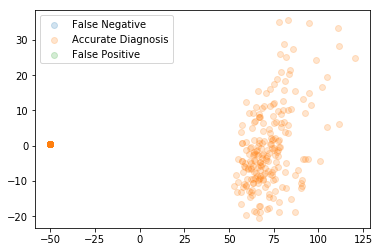

1.0

In [152]:
display_visual(clf)
clf.score(X_test, y_test)

Uh...hmm<br/>So, for context: the work is no longer visible here, but originally when I had done this I got ~72% accuracy.
I figured that was fine for a first pass, and went on to do a grid search on different SVMs to try and find a good
model that way. It was taking a really long time to run the grid search, so I figured I'd try and eliminate some
variables by grayscaling the images. I had assumed this would, if anything, reduce my accuracy because I'd made an
earlier attempt to use only the blue part of the rgb values and got slightly reduced accuracy. Anyways, after some
fiddling around I've discovered a few things that I can show off with some visuals.

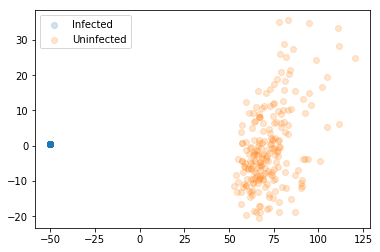

In [158]:
"""
Here, I'm making a quick and dirty scatter plot that shows the distribution of the different cases based on the PCA
transformed X
"""

X_dim = [[],[]]
Y_dim = [[],[]]
for i in range(len(y)):
    if(y[i] == 1):
        X_dim[0].append(X_pca[i][0])
        Y_dim[0].append(X_pca[i][1])
    else:
        X_dim[1].append(X_pca[i][0])
        Y_dim[1].append(X_pca[i][1])
plt.scatter(X_dim[0], Y_dim[0], label="Infected", alpha=.2)
plt.scatter(X_dim[1], Y_dim[1], label="Uninfected", alpha=.2)
plt.legend()
plt.show()

In [159]:
"""
So, this is alarming in its own different way, because at first glance, it looks as though there is somehow only one
case in which the patient is infected with malaria, but...
"""

len(X_dim[0])

311

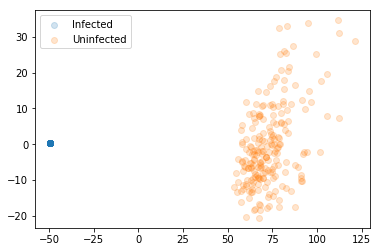

In [167]:
"""
That shows that there are indeed, 311 positive cases. They are just stacked so closely on top of each other that it
is impossible to tell where one ends and the next begins. What is incredibly interesting about this is that the PCA
isn't even fitted using the y values. It found, completely unprompted, a pattern between the distribution of color in
the infected cells. There is however, leakage into the PCA model, so I'll make another one using only training data
and see if the situation remains the same
"""

pca_new = PCA(n_components = 2)
pca_new.fit(X_train)
X_pca_new = pca_new.transform(X)


X_dim = [[],[]]
Y_dim = [[],[]]
for i in range(len(y)):
    if(y[i] == 1):
        X_dim[0].append(X_pca_new[i][0])
        Y_dim[0].append(X_pca_new[i][1])
    else:
        X_dim[1].append(X_pca_new[i][0])
        Y_dim[1].append(X_pca_new[i][1])
plt.scatter(X_dim[0], Y_dim[0], label="Infected", alpha=.2)
plt.scatter(X_dim[1], Y_dim[1], label="Uninfected", alpha=.2)
plt.legend()
plt.show()

In [165]:
"""
And, the new scatterplot looks basically the same as the last one. So, in a wild twist of fate, it's pretty clear to
see that using just the pca and something as simple as a linear classifier, you could easily produce a model which,
for the data provided, is 100% accurate. I think this is possible because the classification problem here is an really
simple one. The stain makes it so that the amoeba shows up in the cell much brighter than anything else, so even when
you can't see the color, you only need to look for some blob of a different shade than the rest of the cell. For my
own peace of mind, I'm still going to run a cross validation on it in order to double check that there isn't any
leakage. Past that, the only way that I can imagine that there would be leakage is if there are duplicate images and
somehow the ended up in both the training and testing sets. Cross validation should help to mitigate that concern, but
there is still a low probability.
"""

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
scores

array([1., 1., 1., 1., 1.])

While this is a weird thing to complain about, I kind of wish there was some error in the model so that I could 
demonstrate optimization for coverage of positive cases (because not being diagnosed with malaria when you have it is
pretty obviously worse than being diagnosed with it when you don't). Oh, well. The dataset that I used will be in the repository with this notebook, but it can also be found on kaggle, although that dataset is pre-split into training and testing sets.